# Trap Optimization

#### We have a desired intensity field. We are seeking a phase such that the intensity field has desired characteristics. For this purpose, implement a direct search algorithm (DSA), where we 
#### - choose a trial phase field
#### - pick random pixel 
#### - change value of that pixel, and get a new intensity $I_m$
#### - generate metric, and decide whether to accept or reject change
#### - Iterate

## Begin with desired intensity hologram
#### $M$ bright spots, each bright spot at location $r_{m}$
#### Say the field is a DoG
$u(\xi,\eta,z) = \frac{-u_{0}\, i\pi}{\lambda z}e^{ikz + \frac{i\pi}{\lambda z}(\xi^2 + \eta^2)} \times [\frac{1}{a}e^{-\frac{\pi^2}{\lambda^2 z^2 a}(\xi^2+\eta^2)} - \frac{1}{b}e^{-\frac{\pi^2}{\lambda^2 z^2 b}(\xi^2+\eta^2)}]$, where $a = (\frac{1}{\Sigma^2}-\frac{i\pi}{\lambda z})$ and $b = (\frac{1}{\sigma^2}-\frac{i\pi}{\lambda z})$

In [707]:
import numpy as np
from scipy import special as sp
from scipy import constants as sc
from matplotlib import pyplot as plt

#define relevant quantities
P = 1 #power ~ 1 Watt
pi = sc.pi
e_0 = sc.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
k = 2*pi/wavelength
w_0 = 1*10**-6 #beam waist
z_R = pi*w_0**2/wavelength #Rayleigh range (~2.9 um)
f = 2*10**-6 #choose some other value that may be more accurate
u_0 = np.sqrt(P/(pi*(w_0**2*(1+(f/z_R)**2)))) #intensity is proportional to u_0^2. And u_0^2 is power/area

def get_int_d_DoG():
    #first step is to have an array for the hologram. This is the intensity, discretized. So, basically, this would be
    #I_m(D)
    z = f
    kappa = 1j*pi/(wavelength*z) #quantity to simplify calculations
    Sigma, sigma  = 10*f, 5*f #Sigma (larger value) and sigma define our fat and narrow gaussians resp.
    a, b = (1/Sigma**2 - kappa), (1/sigma**2 - kappa)
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))
    u_d_DoG = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))], dtype="complex_") #desired field
    int_d_DoG = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))]) #desired intensity of the hologram, DoG
    #my_hist = [] #a histogram to map out distributions of intensity values @ hologram
    for xi in range(len(xlist)):
        for yi in range(len(ylist)):
            #xi and yi will denote the pixel
            x, y = xlist[xi], ylist[yi]
            u = -kappa*u_0 *  np.exp(1j*k*z + kappa*(x**2+y**2)) * \
            ((1/a) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*a)) - \
            (1/b) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*b)))
            I = np.imag(u)**2 + np.real(u)**2
            u_d_DoG[xi][yi] = u
            int_d_DoG[xi][yi] = I
    #counter = [x for x in int_d_DoG.flatten() if x!=0] #found 436 pixels
    #print(len(counter))
    #        my_hist.append(I)
    #plt.figure(0)
    #plt.imshow(int_d_DoG, cmap = 'gray', interpolation = 'nearest')
    #plt.colorbar()
    ###distribution of intensities
    #plt.figure(1)
    #a = np.hstack(my_hist)
    #plt.hist(a, density=False, bins='auto') 
    #plt.ylabel('counts')
    #plt.xlabel('$\mathrm{log}_{10}$ intensity')
    #plt.show()
    return u_d_DoG

def get_radius():
    y,z = 0,f
    kappa = 1j*pi/(wavelength*z) #quantity to simplify calculations
    Sigma, sigma  = 10*f, 5*f #Sigma (larger value) and sigma define our fat and narrow gaussians resp.
    a, b = (1/Sigma**2 - kappa), (1/sigma**2 - kappa)
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    intlist = [] #intensity list
    for x in xlist:
        u = -kappa*u_0 *  np.exp(1j*k*z + kappa*(x**2+y**2)) * \
        ((1/a) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*a)) - \
        (1/b) * np.exp(-pi**2 * (x**2+y**2) /(wavelength**2*z**2*b)))
        I = np.imag(u)**2 + np.real(u)**2
        intlist.append(I)
    I_center = intlist[int(len(xlist)/2)]
    plt.plot(xlist, np.log10(intlist),'r-')
    index = [q for q, value in enumerate(intlist) if value > I_center]
    print('limit @ r = ', abs(xlist[index[0]]))
    return

41
limit @ r =  4.141414141414142e-05


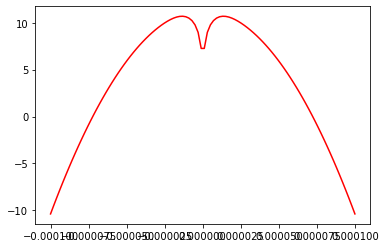

In [706]:
get_radius()

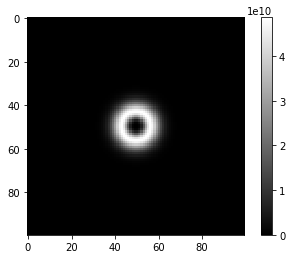

In [407]:
get_int_d_DoG()

#### Notes:
#### One of the degrees of freedom is the DoG shape, defined by $\Sigma$ and $\sigma$, and we can choose what suits our fancy. They ought to be ~$f$. 

## Metropolis Algo

In [727]:
import random
from numpy import fft
import sys
np.set_printoptions(threshold=sys.maxsize) #to view full array

#first, we need a function that takes an array of phase, and returns value of pixels. And we need another function 
    #that does the reverse.
def pixelate(Phi):
    #Phi goes from 0->2*pi
    Phi_discrete = Phi.copy()
    for row in range(len(Phi)):
        for col in range(len(Phi)):
            Phi_discrete[row][col] = np.rint(Phi[row][col]/(2*pi) * 256) #[0,255]
    return Phi_discrete

def unpixelate(Phi_discrete):
    #Phi_discrete goes from 0->255
    Phi = Phi_discrete.copy()
    for row in range(len(Phi_discrete)):
        for col in range(len(Phi_discrete)):
            Phi[row][col] = np.rint(Phi_discrete[row][col]*(2*pi) / 256) #[0,2*pi]
    return Phi

def fourier_transf():
    #input a scalar field, perform a fourier transform, and obtain phase and amplitude
    u = get_int_d_DoG() #DoG
    u_f = fft.fft2(u)
    magnitude = np.abs(u_f)
    phase = np.angle(u_f) #+ pi #shift from [-pi,pi] -> [0, 2*pi]
    return phase

def transf_function(rho_j, phi_j): #rho_j and phi_j
    #for every pixel in the DOE, there exists a transfer function
    xmax, dx = 10e-5, 10e-7
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))    
    T = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))], dtype="complex_")
    for x_index in range(len(T)):
        for y_index in range(len(T)):
            x = xlist[x_index]
            y = ylist[y_index]
            r = np.sqrt(x**2 + y**2)
            if x!= 0:
                theta = np.arctan(y/x)
            else:
                theta = pi/2
            arg = -1j*k/f * (r*rho_j*np.cos(phi_j-theta))
            T[x_index][y_index] = np.exp(arg)
    return T

def aperture():
    #return an array full of zeros and 1, that simulates a top-hat function (1 inside aperture, 0 outside)
    xmax, dx = 10e-5, 10e-7
    u = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))])
    r_lim = 4.141414141414142e-05 #calculated from before
    xlist = np.linspace(-xmax, xmax, int(xmax/dx))
    ylist = np.linspace(-xmax, xmax, int(xmax/dx))
    for xi in range(len(xlist)):
        for yi in range(len(ylist)):
            r = np.sqrt(xlist[xi]**2 + ylist[yi]**2)
            if r<r_lim:
                u[xi][yi]=1
    #plt.imshow(u, cmap = 'gray', interpolation = 'nearest')
    #plt.colorbar()
    #plt.show()
    return u
            
def metropolis(nruns): 
#1. provide the initial scalar amplitude and trial phase
    n, C_list = 0, []
    phase = fourier_transf() 
    u = aperture()
    #obtain the desired intensity
    I_d = np.real(get_int_d_DoG())**2 + np.imag(get_int_d_DoG())**2
    norm_I_d = I_d / np.sum(I_d.flatten()) #normalize the intensity matrix for calculation of the metric
#2. plot the initial phase and intensity
    plt.figure(0)
    plt.imshow(u**2, cmap = 'gray', interpolation = 'nearest')
    plt.title('intensity before')
    plt.colorbar()
    plt.figure(1)
    plt.imshow(phase, cmap = 'gray', interpolation = 'nearest')
    plt.title('phase before')
    plt.colorbar()
    plt.figure(420)
    plt.imshow(I_d, cmap = 'gray', interpolation = 'nearest')
    plt.title('desired intensity')
    plt.colorbar()
    #begin loop
    while n < nruns:
#3. We first pixelate trial phase.
        mylen = len(phase)
        Phi_discrete = pixelate(phase)
        Phi_discrete_upd = Phi_discrete.copy() #make a copy
#4. get a random location, a random value, and the current value
        random_loc = [random.randrange(0,mylen), random.randrange(0,mylen)]
        current_px = Phi_discrete[random.randrange(0,mylen)][random.randrange(0,mylen)]
        random_px = random.randrange(0,256) 
        while current_px == random_px:
            random_px = random.randrange(0,256) 
        Phi_discrete_upd[random_loc[0]][random_loc[1]] = random_px #update phase
        new_phase = unpixelate(Phi_discrete_upd)
#5. for these random values, we need to compute phi_j, delta_phi_j, so the corresponding change in the field
        #may be found. rho_j, as well
        phi_j, delta_phi_j = random_px*2*pi/256, (random_px-current_px)*2*pi/256
        xmax, dx = 10e-5, 10e-7
        rho_j = np.sqrt((-xmax+(random_loc[0]*dx/mylen))**2 + (-xmax+(random_loc[1]*dx/mylen))**2)
#6. now, let's see how it affects the field
        K = np.exp(1j*new_phase)
        K_inv = np.conj(K)
        T = transf_function(rho_j,phi_j)
        E = np.exp(1j*phase) * T * np.exp(1j*(current_px*2*pi/256)) * u #existing field
        delta_E = K_inv * T * np.exp(1j*phi_j) * (np.exp(1j*delta_phi_j)-1) * u
#7. add this to the existing field
        E_new = E + delta_E
#8. Obtain current intensity, normalized.
        I = np.real(E_new)**2 + np.imag(E_new)**2
        norm_I = I / np.sum(I.flatten())
#9. obtain the parameters gamma, sigma, f=1/2, for our metric C.
        gamma = np.sum(norm_I_d*norm_I)/np.sum(norm_I_d**2)
        sigma = np.sqrt(1/41 * np.sum((norm_I - gamma*norm_I_d)**2)) #41 px where non-zero intensity
        C = -np.average(norm_I) + (1/4 * sigma)
        C_list.append(C)
#9b)#trying other metrics: U
        xi = I/I_d
        xi = np.where(np.isnan(xi), 0, xi)
        xi_max = np.max(xi)
        xi_min = np.min([x for x in xi.flatten() if x!= 0])
#9c)#yet another metric: chisq
        eps = 0.8 #diffraction efficiency
        chisq = np.sum((norm_I - eps*norm_I_d)**2)
#10. Last step is to accept changes, or not, and update counter (or set threshold?).
        if len(C_list) > 1:
            if C == min(C_list):
                E = E_new #question: do I have to update u???
                phase = new_phase
                u = np.sqrt(I)
                print(C, -np.average(norm_I), gamma, 1/2*sigma)
        elif len(C_list) == 1: #accept on the first run
                E = E_new 
                phase = new_phase
        n += 1
#11. Plot final phase, final intensity
    plt.figure(3)
    plt.imshow(I, cmap = 'gray', interpolation = 'nearest')
    plt.title('intensity after ' + str(nruns) + ' runs')
    plt.colorbar()
    plt.figure(4)
    plt.imshow(phase, cmap = 'gray', interpolation = 'nearest')
    plt.title('phase after ' + str(nruns) + ' runs')
    plt.colorbar()
    return

0.0009486098041621286 -9.999999999999999e-05 0.37314195031842523 0.0020972196083242573
0.0009006460904247779 -0.0001 0.36963458698321483 0.002001292180849556
0.0008091889751301323 -0.00010000000000000002 0.36117009223151153 0.0018183779502602647
0.0008080325597379411 -0.0001 0.3581517360828612 0.0018160651194758823


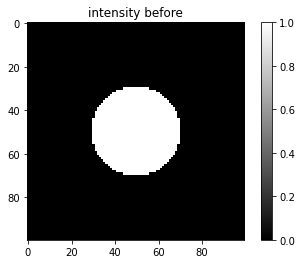

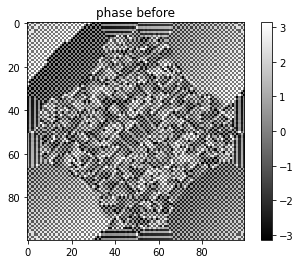

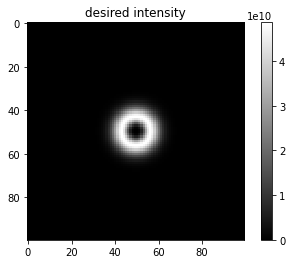

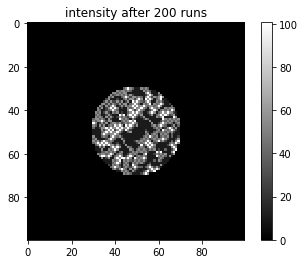

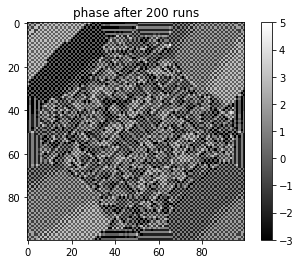

In [729]:
metropolis(200)

#### Next Steps:
#### 1. Get radius for intensity. Define region of interest as lying inside this circle.  DONE
#### 2. Recalculate E_m by setting intensity to 1 inside this region, 0 outside (top hat function). ALMOST DONE (is aperture too large?)
#### 3. Get metrics
#### 4. Check out behaviors 